# 导入相关库

In [2]:
from keras.layers import*
from keras.applications.resnet50 import ResNet50,preprocess_input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from scipy import misc
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import h5py
import os
import pandas as pd
from keras.optimizers import Adam
from keras.models import model_from_json

# 模型构建

In [5]:
image_size=(224,224)
width = image_size[0]
height = image_size[1]
input_tensor = Input((height, width, 3))
x = input_tensor
model_res = ResNet50(input_tensor=x, weights='imagenet', include_top=False)


for layers in model_res.layers:
    layers.trainable = False
    
x = GlobalAveragePooling2D()(model_res.output)
x = Dropout(0.25)(x)
x = Dense(1)(x)
x = Activation('sigmoid')(x)
model = Model(model_res.input, x)

# 读取数据

In [35]:
np.random.seed(20171001)

n = 25000
X = np.zeros((n, 224, 224, 3), dtype=np.float16)
y = np.zeros((n, 1), dtype=np.uint8)

for i in tqdm(range(n//2)):
    X[i] = misc.imresize(misc.imread('../train/cat.%d.jpg' % i), image_size)
    X[i+n//2] = misc.imresize(misc.imread('../train/dog.%d.jpg' % i),image_size)

y[n//2:] = 1

100%|██████████| 12500/12500 [03:53<00:00, 53.59it/s]


## 数据预处理

In [36]:
X = X[..., ::-1]
X[..., 0] -= 103.939
X[..., 1] -= 116.779
X[..., 2] -= 123.68

In [39]:
with h5py.File('X.h5') as h:
    h.create_dataset("X",data=X)

In [3]:
with h5py.File('X.h5', 'r') as h:
    X = np.array(h['X'])

## 切分训练集和测试集

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

### 保存数据

In [7]:
with h5py.File('ResNet50_train_data.h5') as h:
    h.create_dataset("train",data=X_train)
    h.create_dataset("valid", data=X_valid)
    h.create_dataset("y_train", data=y_train)
    h.create_dataset("y_valid", data=y_valid)

# 模型训练

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
save_model = ModelCheckpoint('ResNet50{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True)


model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=16, epochs=20, validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping,save_model])

Train on 22500 samples, validate on 2500 samples
Epoch 1/20
22500/22500 [==============================] - 960s - loss: 0.1099 - acc: 0.9574 - val_loss: 0.0736 - val_acc: 0.9752
Epoch 2/20
22500/22500 [==============================] - 934s - loss: 0.0786 - acc: 0.9704 - val_loss: 0.0453 - val_acc: 0.9816
Epoch 3/20
22500/22500 [==============================] - 933s - loss: 0.0780 - acc: 0.9716 - val_loss: 0.0436 - val_acc: 0.9836
Epoch 4/20
22500/22500 [==============================] - 932s - loss: 0.0786 - acc: 0.9713 - val_loss: 0.0454 - val_acc: 0.9820
Epoch 5/20
22500/22500 [==============================] - 932s - loss: 0.0730 - acc: 0.9728 - val_loss: 0.0452 - val_acc: 0.9816
Epoch 6/20
22500/22500 [==============================] - 934s - loss: 0.0738 - acc: 0.9725 - val_loss: 0.0414 - val_acc: 0.9812
Epoch 7/20
22500/22500 [==============================] - 932s - loss: 0.0707 - acc: 0.9739 - val_loss: 0.0558 - val_acc: 0.9824
Epoch 8/20
22500/22500 [========================

In [30]:
import matplotlib.pyplot as plt

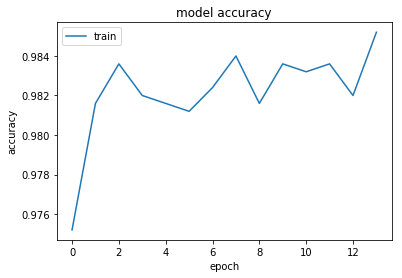

In [31]:
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

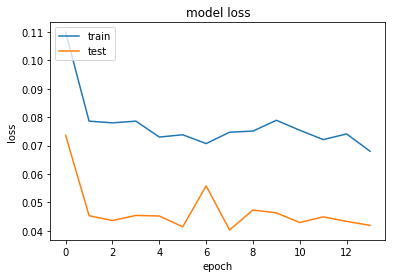

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 保存模型

In [6]:
json_string = model.to_json()
open('ResNet50.json','w').write(json_string)

81619

# 预测结果

In [7]:
model = model_from_json(open('ResNet50.json').read())    
model.load_weights('ResNet5007-0.04.h5')

In [10]:
filenames = os.listdir('../test')
file_ob_path = [os.path.join('../test',file) for file in filenames]
n = len(file_ob_path)

X_test = np.zeros((n, 224, 224, 3), dtype=np.float32)

for i in tqdm(range(n)):
    X_test[i] = misc.imresize(misc.imread(file_ob_path[i]), (224,224))

100%|██████████| 12500/12500 [01:35<00:00, 130.58it/s]


In [11]:
X_test = X_test[..., ::-1]
X_test[..., 0] -= 103.939
X_test[..., 1] -= 116.779
X_test[..., 2] -= 123.68

In [12]:
y_pred = model.predict(X_test,batch_size=16, verbose=1)

12500/12500 [==============================] - 534s   


In [13]:
y_pred = y_pred.clip(min=0.005, max=0.995)
_id = [int(i.split('.')[0]) for i in filenames]

In [14]:
df = pd.DataFrame({'id':_id,'label':y_pred.squeeze()})
df = df.sort_values(by='id')
df.to_csv('sample_submission_Res.csv',index=False)

In [15]:
# 0.06022

# Fine-tune

In [21]:
with h5py.File('ResNet50_train_data.h5','r') as h:
    X_train = np.array(h['train'])
    y_train = np.array(h['y_train'])
    X_valid = np.array(h['valid'])
    y_valid = np.array(h['y_valid'])

In [17]:
model = model_from_json(open('ResNet50.json').read())    
model.load_weights('ResNet5007-0.04.h5')

In [18]:
for layer in model.layers[:140]:
    layer.trainable = False
for layer in model.layers[140:]:
    layer.trainable = True

In [19]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
auto_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=0, 
                            mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
save_model = ModelCheckpoint('resnet50_ft{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True)
optimizer=Adam()
model.compile(optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [23]:
model.fit(X_train, y_train, batch_size=16, epochs=10, validation_data=(X_valid, y_valid),
          callbacks=[early_stopping,auto_lr,save_model])

Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 1401s - loss: 0.0693 - acc: 0.9756 - val_loss: 0.0336 - val_acc: 0.9872
Epoch 2/10
22500/22500 [==============================] - 1328s - loss: 0.0329 - acc: 0.9878 - val_loss: 0.0302 - val_acc: 0.9872
Epoch 3/10
22500/22500 [==============================] - 1327s - loss: 0.0222 - acc: 0.9924 - val_loss: 0.0361 - val_acc: 0.9848
Epoch 4/10
22500/22500 [==============================] - 1327s - loss: 0.0178 - acc: 0.9943 - val_loss: 0.0355 - val_acc: 0.9840
Epoch 5/10
22500/22500 [==============================] - 1327s - loss: 0.0138 - acc: 0.9961 - val_loss: 0.0367 - val_acc: 0.9840
Epoch 6/10
22500/22500 [==============================] - 1328s - loss: 0.0132 - acc: 0.9961 - val_loss: 0.0469 - val_acc: 0.9872


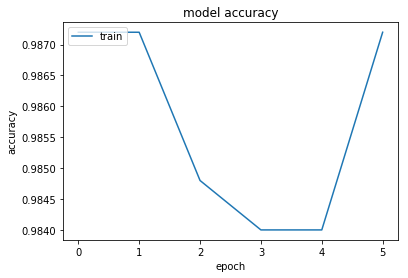

In [35]:
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

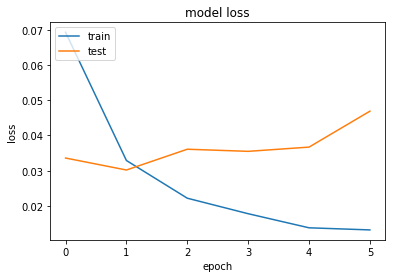

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# 加载最佳模型

In [24]:
model = model_from_json(open('ResNet50.json').read())    
model.load_weights('resnet50_ft01-0.03.h5')

In [25]:
y_pred = model.predict(X_test,batch_size=16, verbose=1)

12500/12500 [==============================] - 602s   


In [26]:
y_pred = y_pred.clip(min=0.005, max=0.995)
_id = [int(i.split('.')[0]) for i in filenames]

In [27]:
df = pd.DataFrame({'id':_id,'label':y_pred.squeeze()})
df = df.sort_values(by='id')
df.to_csv('sample_submission_res_ft.csv',index=False)

In [ ]:
# 微调后的结果0.05376